In [1]:
"""Disable transparent backgrounds for analysis figures to make them look nicer
in both dark and bright mode on the website."""

from quantify_core.analysis import base_analysis as ba

ba.settings["mpl_transparent_background"] = False

In [2]:
from qblox_instruments import Cluster, ClusterType
import tempfile

from quantify_core.data import handling as dh
from quantify_core.measurement.control import MeasurementControl
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent

measurement_control = MeasurementControl("measurement_control")
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")
instrument_coordinator.timeout(60*60*120)
# Create a temporary directory for this tutorial
temp_dir = tempfile.mkdtemp()

# First, don't forget to set the data directory!
dh.set_datadir(temp_dir)

# Device parameters
# RESET_TIME = 1e-3
# INTE_TIME = 20e-6
# ACQ_DELAY = 232e-9
# FREQ_01 = 3.085e9
# READOUT_AMP = 0.037
# READOUT_FREQ = 4.912585086016809e9
# PI_PULSE_AMP = 0.49035467279281136
# PI_PULSE_DURA = 200e-9
# LO_FREQ_QUBIT = FREQ_01 + 150e6
# LO_FREQ_READOUT = 5.2e9

single_qubit_device = QuantumDevice.from_json_file("/Users/ratiswu/Documents/GitHub/Quela_Qblox/qblox_drive_AS/Configs/QPUdr1.json")
single_qubit_device.hardware_config.load_from_json_file("/Users/ratiswu/Documents/GitHub/Quela_Qblox/qblox_drive_AS/Configs/QPUdr1_hcfg.json")
print(single_qubit_device.elements())


['q0', 'q1', 'q2', 'q3']


Next, we connect to a dummy {{ Cluster }}. If you are connecting to an actual cluster, you would provide the
 `identifier` argument (the IP address, device name or serial number) instead
 of the `dummy_cfg` argument.

In [3]:
cluster = Cluster(
    list(single_qubit_device.hardware_config()["hardware_description"].keys())[0],
    identifier = f"qum.phys.sinica.edu.tw", port=5011
)

ic_cluster = ClusterComponent(cluster)

instrument_coordinator.add_component(ic_cluster)

single_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

Finally, we define the hardware configuration:

In [4]:
from quantify_scheduler.operations.gate_library import X, Reset, Measure
from quantify_scheduler.operations.pulse_library import IdlePulse
from quantify_scheduler.enums import BinMode
from quantify_scheduler.schedules.schedule import Schedule
from numpy import ndarray, array, asarray

# original T1 schedule
def t1_sched(
    qubits: list, # list of qubit names
    times,#: Union[np.ndarray, float],
    repetitions: int = 1,
) -> Schedule:
    """
    Generate a schedule for performing simultaneous T1/T2 measurements on n qubits.
    """

    # ensure times and measurements are iterable.
    times = asarray(times)
    times = times.reshape(times.shape or (1,))

    schedule = Schedule("Simultaneous T1", repetitions)
    
    for i, tau in enumerate(times):
        T1_drives = []
        for n, qubit in enumerate(qubits):
            schedule.add(Reset(qubit), label=f"Reset {i}_{n}", ref_pt="start")
            if n==0: # if it's the first excitation
                # drive |0> to |1>
                T1_drive0 = schedule.add(X(qubit), label=f"T1 Pi {i}_{n}")
                T1_drives.append(T1_drive0)
            else:
                # simultaneously drive all qubits to |1>
                T1_drive = schedule.add(X(qubit), ref_op=T1_drive0, ref_pt="start", label=f"T1 Pi {i}_{n}")
                T1_drives.append(T1_drive)
            # measure after some delay, tau
            schedule.add(
                Measure(qubit, acq_index=i, acq_channel=n),
                ref_op=T1_drives[n],
                rel_time=tau,
                label=f"Measurement T1 {i}_{n}",
            )

    return schedule



#### Running the T1 schedule using MeasurementControl

The dataset returned by {{ MeasurementControl }} will in this case have four rows of data, which are: 
- `y0`: contains the data establishing whether a qubit was reset or not
- `y1`: contains the actual (thresholded) measurement
- `y2` and `y3`: filled with NaNs (currently {{ MeasurementControl }} expects {{ ScheduleGettable }} to return IQ values)

Below we run {{ MeasurementControl }} again as before

In [5]:
from qcodes.parameters import ManualParameter
from quantify_scheduler.gettables import ScheduleGettable
from numpy import array, linspace

single_qubit_device.cfg_sched_repetitions(1024)  # run and average 1024 times

# Configure the settable
time = ManualParameter("sample", label="Sample time", unit="s")
time.batched = True
time_axis = (linspace(start=4e-9, stop=1e-3, num=100)*1e9).astype(int)/1e9
meas_qs = ["q1"]
# if times = {"q1":time_axis} or {"q3":time_axis} will work normally

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=t1_sched,
    schedule_kwargs={"qubits": meas_qs,"times":time_axis},
    batched=True,
    num_channels=1,
)

# Configure MeasurementControl
measurement_control.settables(time)
measurement_control.setpoints(time_axis)
measurement_control.gettables(gettable)

dataset = measurement_control.run("t1")

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 sample 
Batch size limit: 100



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

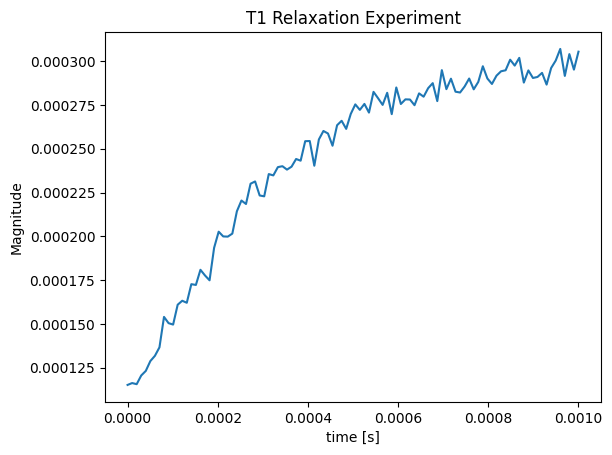

In [6]:
import matplotlib.pyplot as plt

plt.plot(dataset.x0, (dataset.y0.data**2+dataset.y1.data**2)**0.5)
plt.xlabel("time [s]")
plt.ylabel('Magnitude')
plt.title('T1 Relaxation Experiment')
plt.show()